In [1]:
#!pip install torch torchsummary

In [2]:
import numpy as np
import torch
from IPython.display import display, Math
from numpyarray_to_latex.jupyter import to_ltx
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-muted', 'practicals.mplstyle'])
def pprint(*args):
    res = ""
    for i in args:
        if type(i) == np.ndarray:
            res += to_ltx(i, brackets='[]')
        elif type(i) == torch.Tensor:
            res += to_ltx(i.detach().cpu().numpy(), brackets='[]',)
        elif type(i) == str:
            res += i
    display(Math(res))

In [3]:
import torch.nn as nn

class Simple2LayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation
        x = self.fc2(x)    # linear output for regression
        return x

# Instantiate the network and define SSE-like loss
model = Simple2LayerMLP(input_dim=10, hidden_dim=15, output_dim=1)
criterion = nn.MSELoss(reduction='sum')  # SSE (sum of squared errors)
eta = 1e-2

# Dummy data
X_sample = torch.randn(5, 10)
y_sample = torch.randn(5, 1)

y_pred = model(X_sample)
loss = criterion(y_pred, y_sample)

# Backpropagate
loss.backward()

# Gradient descent step
with torch.no_grad():
    for param in model.parameters():
        param -= eta * param.grad
        param.grad.zero_()

In [4]:
import torch.optim as optim

model = Simple2LayerMLP(10, 15, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training... then save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 10
}, "checkpoint.pth")

# Later, to resume
checkpoint = torch.load("checkpoint.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

# For inference, only model_state_dict is strictly required.

In [5]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# This CNN will perform a regression task (e.g., predicting a real-valued output from an image).
# We'll use two convolution layers (with 2x2 max pooling after each), then two fully-connected layers,
# include dropout with probability=0.25, and weight decay in the optimizer for regularization.

class SimpleCNNRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        
        # Second convolution
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        # After two 2x2 pools on a 28x28 input, the spatial dimension goes 28->14->7
        # => final feature map is 16 x 7 x 7 = 16*7*7 = 784
        self.fc1   = nn.Linear(16 * 7 * 7, 64)  
        self.fc2   = nn.Linear(64, 1)          # single output for regression
        
        # Dropout layer to help regularize the fully connected part
        self.dropout = nn.Dropout(p=0.25)
        
        # MaxPool layer (2x2) used after each convolution
        self.pool   = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First conv: conv1 -> ReLU -> pool => shape: (N, 8, 14, 14)
        x = self.conv1(x)        
        x = F.relu(x)
        x = self.pool(x)
        
        # Second conv: conv2 -> ReLU -> pool => shape: (N, 16, 7, 7)
        x = self.conv2(x)        
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten => shape: (N, 16*7*7 = 784)
        x = x.view(x.size(0), -1)
        
        # First fully connected => ReLU => Dropout => shape: (N, 64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Final fully connected => shape: (N, 1)
        x = self.fc2(x)
        return x

# We'll create some dummy data for regression:
# - Shape of X: (N, 1, 28, 28)
# - Shape of y: (N, 1) containing continuous values
N_train = 1000
N_val   = 200
X_train = torch.randn(N_train, 1, 28, 28)
y_train = torch.randn(N_train, 1)  # random continuous targets
X_val   = torch.randn(N_val, 1, 28, 28)
y_val   = torch.randn(N_val, 1)

# We'll wrap the data in TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
batch_size    = 50
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# Instantiate our CNN model
model = SimpleCNNRegression()

# We'll use MSELoss for this regression task
criterion = nn.MSELoss()

# We'll use Adam optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Setup for training with early stopping
max_epochs         = 20
patience           = 3  # number of epochs with no improvement allowed
best_val_loss      = float('inf')
epochs_no_improve  = 0
best_model_path    = "best_model.pth"

for epoch in range(max_epochs):
    # Train mode: enables dropout, etc.
    model.train()
    running_train_loss = 0.0
    
    # Fetch mini-batches from the training loader
    for X_batch, y_batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass -> compute predictions
        preds = model(X_batch)
        
        # Compute MSE loss for regression
        loss = criterion(preds, y_batch)
        
        # Backward pass -> compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Compute average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase (disable dropout, etc.)
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for Xv_batch, yv_batch in val_loader:
            # Forward pass on validation set
            val_preds = model(Xv_batch)
            val_loss = criterion(val_preds, yv_batch)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{max_epochs}]  "
          f"Train MSE: {avg_train_loss:.4f}  "
          f"Val MSE: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        # If validation improves, update best_val_loss and reset patience counter
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save current model as best
        torch.save(model.state_dict(), best_model_path)
        print("  Best model saved (improved validation MSE).")
    else:
        epochs_no_improve += 1
        # If no improvement for 'patience' epochs, stop
        if epochs_no_improve >= patience:
            print("Early stopping triggered (no improvement).")
            break

print("\nTraining complete. Loading best model for final checks.")
best_model = SimpleCNNRegression()
best_model.load_state_dict(torch.load(best_model_path, weights_only=False))
best_model.eval()

# We can now evaluate 'best_model' on the validation set (or test set if we had one).
# For instance, a quick check of final validation MSE:
final_val_loss = 0.0
with torch.no_grad():
    for Xv_batch, yv_batch in val_loader:
        val_preds = best_model(Xv_batch)
        val_loss = criterion(val_preds, yv_batch)
        final_val_loss += val_loss.item()
print(f"Final validation MSE (best model): {final_val_loss / len(val_loader):.4f}")

Epoch [1/20]  Train MSE: 0.9465  Val MSE: 1.1579
  Best model saved (improved validation MSE).


Epoch [2/20]  Train MSE: 0.9246  Val MSE: 1.1518
  Best model saved (improved validation MSE).


Epoch [3/20]  Train MSE: 0.9266  Val MSE: 1.1536
Epoch [4/20]  Train MSE: 0.9203  Val MSE: 1.1599


Epoch [5/20]  Train MSE: 0.9085  Val MSE: 1.1604
Early stopping triggered (no improvement).

Training complete. Loading best model for final checks.
Final validation MSE (best model): 1.1518


In [6]:
# Creating a tensor from a Python list
data_list = [[1, 2, 3], [4, 5, 6]]
x_data = torch.tensor(data_list)
pprint("\\text{Tensor from list:}", x_data)

# Creating a tensor from a NumPy array
np_array = np.array(data_list)
x_np = torch.from_numpy(np_array)
pprint("\\text{Tensor from NumPy array:}", x_np)

# Verify that modifying the NumPy array changes the tensor (shared memory)
np_array[0, 0] = 99
pprint("\\text{After modifying the NumPy array, the Tensor becomes:}", x_np)

# Creating tensors using factory functions
shape = (2, 3)
x_zeros = torch.zeros(shape)
x_ones = torch.ones(shape)
x_rand = torch.rand(shape)
pprint("\\text{Zero Tensor:}", x_zeros)
pprint("\\text{Ones Tensor:}", x_ones)
pprint("\\text{Random Tensor:}", x_rand)

# Creating tensors based on existing ones
x_like = torch.ones_like(x_rand)        # tensor of ones with same shape as x_rand
x_like_float = torch.rand_like(x_data, dtype=torch.float32)  # random tensor with same shape as x_data, but forced float type
pprint("\\text{Ones-like Tensor:}", x_like)
pprint("\\text{Rand-like Tensor with float32 dtype:}", x_like_float)

# Checking tensor attributes
print("Tensor shape:", x_data.shape)
print("Tensor data type:", x_data.dtype)
print("Tensor device:", x_data.device)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Tensor shape: torch.Size([2, 3])
Tensor data type: torch.int64
Tensor device: cpu


In [7]:
# Element-wise arithmetic operations
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([4.0, 5.0, 6.0])

pprint("a=", a)
pprint("b=", b)
pprint("a + b =", a + b)        # element-wise addition
pprint("a \\times b =", a * b)        # element-wise multiplication
pprint("a - b =", a - b)        # element-wise subtraction
pprint("\\frac{a}{b} =", a / b)        # element-wise division

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
# Matrix multiplication vs elementwise
A = torch.tensor([[1, 2],
                  [3, 4]])
B = torch.tensor([[5, 6],
                  [7, 8]])
pprint("A=", A)
pprint("B=", B)
pprint("\\text{Element-wise multiply:}", A * B)   # same shape -> elementwise product
pprint("\\text{Matrix multiply:}", A @ B)         # 2x2 @ 2x2 -> 2x2 matrix result

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
# Create a 2-D tensor (matrix) for demonstration
x = torch.tensor([[10, 11, 12],
                  [20, 21, 22],
                  [30, 31, 32]])
pprint("\\text{Original tensor: }", x)

# Indexing a single element
pprint("\\text{Element at (0, 1): }", str(x[0, 1].item()))   # .item() to get Python scalar

# Slicing rows and columns
pprint("\\text{First row: }", x[0])            # equivalent to x[0, :]
pprint("\\text{Last column: }", x[:, -1])       # all rows, last column

# Slice a submatrix (e.g., top-left 2x2 block)
sub_x = x[0:2, 0:2]   # rows 0-1 and cols 0-1
pprint("\\text{Top-left 2x2 sub-tensor: }", sub_x)

# Modify part of the tensor
x[1:, 1:] = torch.tensor([[ -1, -2],
                          [ -3, -4]])   # set bottom-right 2x2 block to new values
pprint("\\text{Tensor after modification: }", x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
# Reshape (view) a tensor
t = torch.arange(16)        # 1-D tensor [0, 1, 2, ..., 15]
pprint("t=", t)

t_matrix = t.reshape(4, 4)  # reshape to 4x4 matrix
pprint("\\text{t reshaped to 4x4: }", t_matrix)

# Transpose the matrix (swap dimensions)
pprint("t^T:\ ", t_matrix.T)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
# Concatenate two tensors
t1 = torch.tensor([[1, 2, 3],
                   [4, 5, 6]])
t2 = torch.tensor([[7, 8, 9],
                   [10, 11, 12]])
t_cat0 = torch.cat([t1, t2], dim=0)  # concatenate along rows (dim=0)
t_cat1 = torch.cat([t1, t2], dim=1)  # concatenate along columns (dim=1)

pprint("t_1=", t1)
pprint("t_2:=", t2)
pprint("t_1\\text{ and }t_2\\text{  concatenated along dim=0: }", t_cat0)
pprint("t_1\\text{  and }t_2\\text{  concatenated along dim=1: }", t_cat1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
# A simple autograd example: y = f(x) where f(x) = x^2 + 2x + 1
x = torch.tensor(3.0, requires_grad=True)   # define a tensor x with gradient tracking
print("x:", x)

# Define a function of x
y = x**2 + 2*x + 1
print("y:", y)

# Compute the gradient dy/dx by calling backward on y
y.backward()    # computes gradient of y w.r.t. x
print("dy/dx at x=3:", x.grad)

x: tensor(3., requires_grad=True)
y: tensor(16., grad_fn=<AddBackward0>)
dy/dx at x=3: tensor(8.)


In [13]:
# Autograd with two inputs: z = x * y + y^2
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(-3.0, requires_grad=True)

z = x * y + y**2   # z is a function of both x and y
print("z:", z)

z.backward()  # Compute gradients dz/dx and dz/dy
print("dz/dx:", x.grad)   # should be y
print("dz/dy:", y.grad)   # should be x + 2y

z: tensor(3., grad_fn=<AddBackward0>)
dz/dx: tensor(-3.)
dz/dy: tensor(-4.)


In [14]:
# Broadcasting example: add a vector to each row of a matrix
mat = torch.tensor([[0, 0, 0],
                    [10, 10, 10],
                    [20, 20, 20],
                    [30, 30, 30]])   # shape (4,3)
vec = torch.tensor([1, 2, 3])        # shape (3,)

result = mat + vec  # vec is broadcast to shape (4,3)
pprint("M=", mat)
pprint("V=", vec)
pprint("M+V", result)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
# Device-agnostic code: choose CPU or CUDA
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print("Using device:", device)

# Create a tensor on the chosen device
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("x device:", x.device)

# Alternatively, move an existing tensor to the device
y = torch.ones(3)            # defaults to CPU
y = y.to(device)             # move to GPU if available
print("y device:", y.device)

Using device: mps
x device: mps:0
y device: mps:0


In [16]:
import time

# Large tensor operation on CPU vs GPU (if available)
large_cpu = torch.randn(10000, 10000)  # 10000x10000 matrix on CPU
start = time.time()
res_cpu = large_cpu @ large_cpu       # matrix multiply on CPU
end = time.time()
print("CPU computation time:", end - start, "seconds")

if torch.cuda.is_available():
    large_gpu = large_cpu.to("cuda")
    torch.cuda.synchronize()  # ensure data is transferred
    start = time.time()
    res_gpu = large_gpu @ large_gpu   # matrix multiply on GPU
    torch.cuda.synchronize()  # wait for GPU to finish computation
    end = time.time()
    print("GPU computation time:", end - start, "seconds")

if torch.backends.mps.is_available():
    large_gpu = large_cpu.to("mps")
    start = time.time()
    res_gpu = large_gpu @ large_gpu
    end = time.time()
    print("MPS computation time:", end - start, "seconds")

CPU computation time: 4.189410209655762 seconds


MPS computation time: 0.1967308521270752 seconds


In [17]:
tensor = torch.rand(3)
print("Before moving, device:", tensor.device)
if torch.cuda.is_available():
    tensor = tensor.to('cuda')
    print("After moving, device:", tensor.device)
if torch.backends.mps.is_available():
    tensor = tensor.to('mps')
    print("After moving, device:", tensor.device)

Before moving, device: cpu


After moving, device: mps:0


In [18]:
torch.set_default_device(device)

In [19]:
a = torch.ones(5)
pprint("a=", a)

# Out-of-place addition
b = a.add(5)
print("After b = a.add(5):")
pprint("a=", a)  # a should remain unchanged
pprint("b=", b)  # b is the new tensor

# In-place addition
a.add_(5)
print("\nAfter a.add_(5):")
pprint("a=", a)  # a is now changed in-place

<IPython.core.display.Math object>

After b = a.add(5):


<IPython.core.display.Math object>

<IPython.core.display.Math object>


After a.add_(5):


<IPython.core.display.Math object>

In [20]:
x = torch.ones(3)
y = x.mul_(2)   # in-place multiply x by 2
pprint("x=", x)
pprint("y=", y)

pprint("\\text{x after in-place mul\_: }", x)
pprint("\\text{y (result of x.mul\_(2)): }", y)

# Now x is [2,2,2], let's do out-of-place multiply
z = x.mul(3)
pprint("\\text{x after out-of-place mul(3): }", x)  # x remains [2,2,2]
pprint("\\text{z (result of x.mul(3)): }", z)       # z is [6,6,6]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
def g(a):
    """
    Sigmoid function g(a) = 1 / (1 + e^-a)
    """
    return 1.0 / (1.0 + torch.exp(-a))

def gp(a):
    """
    Derivative of the sigmoid function g'(a)
    = exp(-a) / (1 + exp(-a))^2
    """
    return torch.exp(-a) / (1 + torch.exp(-a))**2

In [22]:
# Input
x = torch.tensor([-1.7])  # A single scalar input

# True target
y = torch.tensor([-4.5])  # A single scalar target

# Hidden layer weights
w11_1 = torch.tensor([0.13], requires_grad=True)  # w_{11}^{(1)}
w12_1 = torch.tensor([-2.0], requires_grad=True)  # w_{12}^{(1)}

# Output layer weights
w11_2 = torch.tensor([1.0], requires_grad=True)   # w_{11}^{(2)}
w21_2 = torch.tensor([0.5], requires_grad=True)   # w_{21}^{(2)}

In [23]:
# Hidden neuron 1
a1_1 = w11_1 * x
z1   = g(a1_1)

# Hidden neuron 2
a2_1 = w12_1 * x
z2   = g(a2_1)

# Output neuron
a1_2 = w11_2 * z1 + w21_2 * z2
yhat = g(a1_2)

# Loss
L = (y - yhat)**2

In [24]:
# Symbolic gradients
Sgrad_L_w11_1 = -2 * (y - yhat) * gp(a1_2) * w11_2 * gp(a1_1) * x
Sgrad_L_w12_1 = -2 * (y - yhat) * gp(a1_2) * w21_2 * gp(a2_1) * x
Sgrad_L_w11_2 = -2 * (y - yhat) * gp(a1_2) * z1
Sgrad_L_w21_2 = -2 * (y - yhat) * gp(a1_2) * z2

Sgrad_L_w11_1, Sgrad_L_w12_1, Sgrad_L_w11_2, Sgrad_L_w21_2

(tensor([-0.8892], device='mps:0', grad_fn=<MulBackward0>),
 tensor([-0.0563], device='mps:0', grad_fn=<MulBackward0>),
 tensor([0.9424], device='mps:0', grad_fn=<MulBackward0>),
 tensor([2.0494], device='mps:0', grad_fn=<MulBackward0>))

In [25]:
# Reset gradients (in case this cell is run multiple times)
w11_1.grad = None
w12_1.grad = None
w11_2.grad = None
w21_2.grad = None

# Perform backprop
L.backward()

# Automatic gradients
grad_L_w11_1 = w11_1.grad
grad_L_w12_1 = w12_1.grad
grad_L_w11_2 = w11_2.grad
grad_L_w21_2 = w21_2.grad

grad_L_w11_1, grad_L_w12_1, grad_L_w11_2, grad_L_w21_2

(tensor([-0.8892], device='mps:0'),
 tensor([-0.0563], device='mps:0'),
 tensor([0.9424], device='mps:0'),
 tensor([2.0494], device='mps:0'))

In [26]:
print("Loss L =", L.item())

print("\n--- dL/dw11^(2) ---")
print("Auto-grad:", grad_L_w11_2.item(), "\t Symbolic:", Sgrad_L_w11_2.item())

print("\n--- dL/dw21^(2) ---")
print("Auto-grad:", grad_L_w21_2.item(), "\t Symbolic:", Sgrad_L_w21_2.item())

print("\n--- dL/dw11^(1) ---")
print("Auto-grad:", grad_L_w11_1.item(), "\t Symbolic:", Sgrad_L_w11_1.item())

print("\n--- dL/dw12^(1) ---")
print("Auto-grad:", grad_L_w12_1.item(), "\t Symbolic:", Sgrad_L_w12_1.item())

Loss L = 27.21538734436035

--- dL/dw11^(2) ---
Auto-grad: 0.942385196685791 	 Symbolic: 0.9423852562904358

--- dL/dw21^(2) ---
Auto-grad: 2.049447774887085 	 Symbolic: 2.049448013305664

--- dL/dw11^(1) ---
Auto-grad: -0.8891823887825012 	 Symbolic: -0.8891823887825012

--- dL/dw12^(1) ---
Auto-grad: -0.05625968053936958 	 Symbolic: -0.05625968798995018


In [27]:
import pandas as pd

# Load the training data
df = pd.read_csv('facial-keypoints-detection/training.csv')
print("Training data shape:", df.shape)
df.head(5)  # show first 5 rows as an example

Training data shape: (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [28]:
# Count non-null values in each column
print(df.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [29]:
# Check total missing values per column
missing_counts = df.isnull().sum()
print("Missing values per column:")
print(missing_counts)

Missing values per column:
left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_l

Number of complete cases (no missing keypoints): 2140


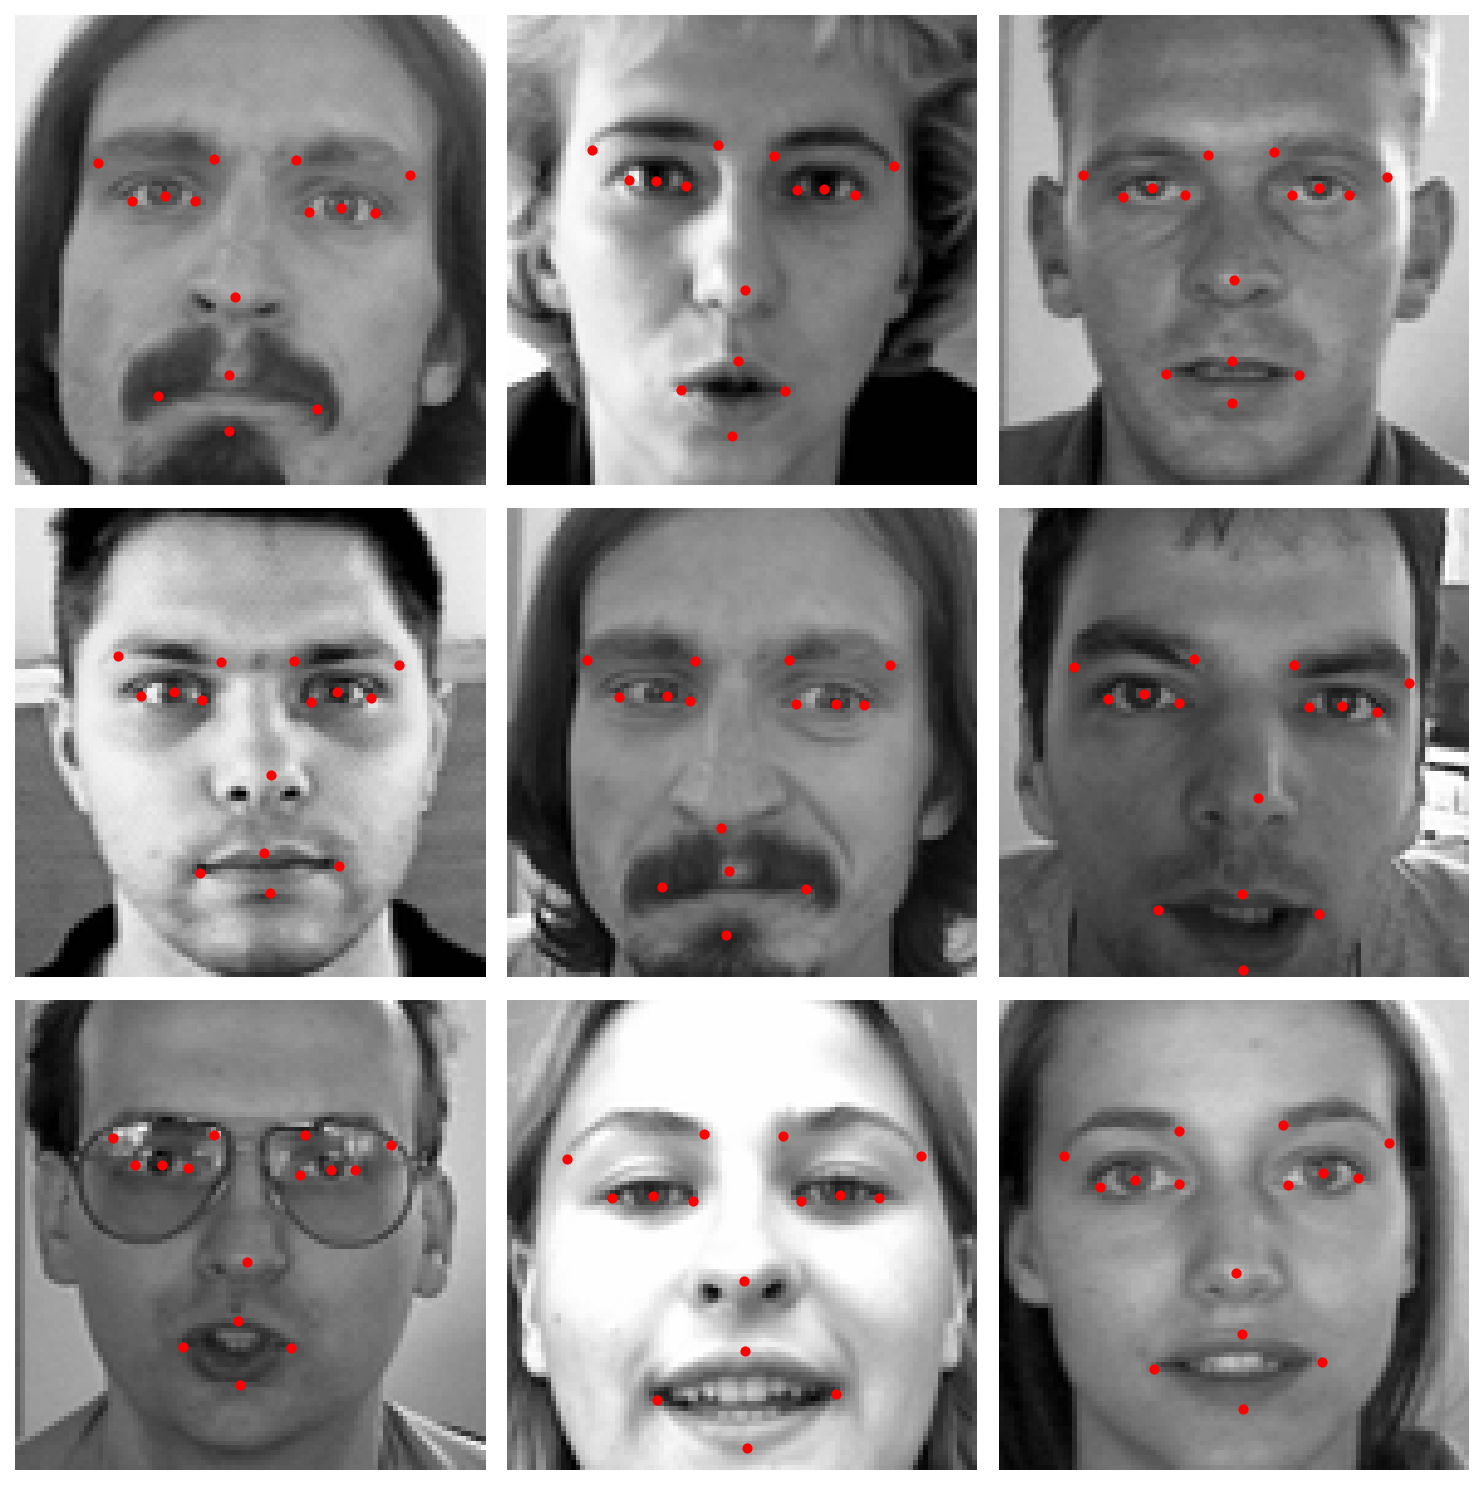

In [30]:
df_complete = df.dropna().reset_index(drop=True)
print("Number of complete cases (no missing keypoints):", len(df_complete))

sample_images = df_complete['Image'].iloc[:9].values
sample_images = [np.fromstring(img_str, sep=' ').reshape(96, 96) for img_str in sample_images]
sample_keypoints = df_complete.iloc[:9, :-1].values  # first 30 columns are keypoints

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i in range(9):
    axes[i].imshow(sample_images[i], cmap='gray')
    # Plot keypoints as red dots
    kp = sample_keypoints[i]
    axes[i].scatter(kp[0::2], kp[1::2], c='red', s=15)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [31]:
# 1. Drop rows with missing values
df = df.dropna().reset_index(drop=True)
print("Remaining training samples after dropping missing:", len(df))

# 2. Convert the 'Image' column from strings to numpy arrays of shape (96,96)
df['Image'] = df['Image'].apply(lambda img: np.fromstring(img, sep=' ', dtype=np.float32))

# 3. Normalize pixel values to [0,1]
df['Image'] = df['Image'].apply(lambda img: img/255.0)

# 4. Convert list of image arrays to a 4D numpy array for model input
X_fcn = np.vstack(df['Image'].values)  # shape (N, 9216)
X_cnn = np.vstack(df['Image'].values).reshape(-1, 1, 96, 96).astype(np.float32)  # (N, 1, 96, 96)

# 5. Prepare keypoint targets as a numpy array
y = df[df.columns[:-1]].values  # all columns except the 'Image' column
y = y.astype(np.float32)
print("X_fcn shape:", X_fcn.shape, "y shape:", y.shape)
print("X_cnn shape:", X_cnn.shape, "y shape:", y.shape)

Remaining training samples after dropping missing: 2140


X_fcn shape: (2140, 9216) y shape: (2140, 30)
X_cnn shape: (2140, 1, 96, 96) y shape: (2140, 30)


In [32]:
class KeypointFCN(nn.Module):
    def __init__(self):
        super(KeypointFCN, self).__init__()
        # We have 96*96 = 9216 input features per image
        self.fc1 = nn.Linear(96*96, 1024)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 30)  # 30 = (x,y) for 15 keypoints

    def forward(self, x):
        # x shape: (batch_size, 9216) 
        # (If x is not already flattened, do x = x.view(x.size(0), -1))
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [33]:
from sklearn.model_selection import train_test_split

# 90/10 train-validation split using X_fcn
X_train_fcn, X_val_fcn, y_train_fcn, y_val_fcn = train_test_split(
    X_fcn, y, test_size=0.1, random_state=42
)

print("Training samples (FCN):", len(X_train_fcn), 
      "Validation samples (FCN):", len(X_val_fcn))

Training samples (FCN): 1926 Validation samples (FCN): 214


In [34]:
train_dataset_fcn = TensorDataset(
    torch.from_numpy(X_train_fcn).to(device),  # shape: (batch_size, 9216)
    torch.from_numpy(y_train_fcn).to(device)   # shape: (batch_size, 30)
)
val_dataset_fcn = TensorDataset(
    torch.from_numpy(X_val_fcn).to(device),
    torch.from_numpy(y_val_fcn).to(device)
)

g = torch.Generator(device=device)
train_loader_fcn = DataLoader(train_dataset_fcn, batch_size=64, shuffle=True, generator=g)
val_loader_fcn = DataLoader(val_dataset_fcn, batch_size=64, shuffle=False)

In [35]:
from torchsummary import summary
fcn_model = KeypointFCN().to(device)
summary(fcn_model.cpu(), X_train_fcn[0].shape)
fcn_model = fcn_model.to(device)
criterion_fcn = nn.MSELoss()  
optimizer_fcn = optim.Adam(fcn_model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       9,438,208
           Dropout-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
           Dropout-4                  [-1, 512]               0
            Linear-5                   [-1, 30]          15,390
Total params: 9,978,398
Trainable params: 9,978,398
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.02
Params size (MB): 38.06
Estimated Total Size (MB): 38.12
----------------------------------------------------------------


In [36]:
from tqdm.auto import tqdm
epochs = 20
for epoch in (pbar:=tqdm(range(1, epochs+1))):
    # --- Training ---
    fcn_model.train()
    train_loss = 0.0
    for batch_images, batch_keypoints in train_loader_fcn:
        outputs = fcn_model(batch_images)
        loss = criterion_fcn(outputs, batch_keypoints)

        optimizer_fcn.zero_grad()
        loss.backward()
        optimizer_fcn.step()

        train_loss += loss.item() * batch_images.size(0)
    train_loss /= len(train_loader_fcn.dataset)

    # --- Validation ---
    fcn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_images, batch_keypoints in val_loader_fcn:
            preds = fcn_model(batch_images)
            loss = criterion_fcn(preds, batch_keypoints)
            val_loss += loss.item() * batch_images.size(0)
    val_loss /= len(val_loader_fcn.dataset)

    pbar.set_description(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
fcn_model.eval()
with torch.no_grad():
    val_preds_fcn = fcn_model(torch.Tensor(X_val_fcn).to(device)).cpu().numpy()
    
val_truth_fcn = y_val_fcn
mse_val_fcn = np.mean((val_preds_fcn - val_truth_fcn)**2)
rmse_val_fcn = np.sqrt(mse_val_fcn)

print(f"Validation RMSE (FCN): {rmse_val_fcn:.3f} pixels")

Validation RMSE (FCN): 10.002 pixels


In [38]:
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # 96x96 -> 94x94 (then 47x47 after pool)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # 47x47 -> 45x45 (then 22x22 after pool)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 22x22 -> 20x20 (then 10x10 after pool)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 10 * 10, 256)  # 128 feature maps * 10 * 10
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 30)  # 30 outputs (x,y for 15 keypoints)
        
    def forward(self, x):
        # Three conv layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout and ReLU
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [39]:
from sklearn.model_selection import train_test_split

# We'll do a 90/10 train-validation split
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn, y, test_size=0.1, random_state=42)
print("Training samples:", len(X_train_cnn), "Validation samples:", len(X_val_cnn))

Training samples: 1926 Validation samples: 214


In [40]:
# Create TensorDatasets for train and validation
train_dataset = TensorDataset(torch.from_numpy(X_train_cnn).to(device), torch.from_numpy(y_train_cnn).to(device))
val_dataset = TensorDataset(torch.from_numpy(X_val_cnn).to(device), torch.from_numpy(y_val_cnn).to(device))

# DataLoader for batching
g = torch.Generator(device=device)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
cnn_model = KeypointCNN()
summary(cnn_model.cpu(), X_train_cnn[0].shape)
cnn_model = cnn_model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             320
         MaxPool2d-2           [-1, 32, 47, 47]               0
            Conv2d-3           [-1, 64, 45, 45]          18,496
         MaxPool2d-4           [-1, 64, 22, 22]               0
            Conv2d-5          [-1, 128, 20, 20]          73,856
         MaxPool2d-6          [-1, 128, 10, 10]               0
            Linear-7                  [-1, 256]       3,277,056
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 30]           3,870
Total params: 3,406,494
Trainable params: 3,406,494
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forw

In [42]:
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

epochs = 20
for epoch in (pbar:=tqdm(range(1, epochs+1))):
    cnn_model.train()
    train_loss = 0.0
    for batch_images, batch_keypoints in train_loader:
        images = batch_images
        keypoints = batch_keypoints

        outputs = cnn_model(images)
        loss = criterion(outputs, keypoints)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase
    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_images, batch_keypoints in val_loader:
            images = batch_images
            keypoints = batch_keypoints
            preds = cnn_model(images)
            loss = criterion(preds, keypoints)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    pbar.set_description(f"Epoch {epoch}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
# Switch to evaluation mode
cnn_model.eval()

# Predict on the entire validation set
with torch.no_grad():
    val_preds = cnn_model(torch.Tensor(X_val_cnn).to(device)).cpu().numpy()

# Compute RMSE on validation set
val_truth = y_val_cnn  # actual keypoints
mse_val = np.mean((val_preds - val_truth)**2)
rmse_val = np.sqrt(mse_val)
print(f"Validation RMSE: {rmse_val:.3f} pixels")

Validation RMSE: 3.136 pixels


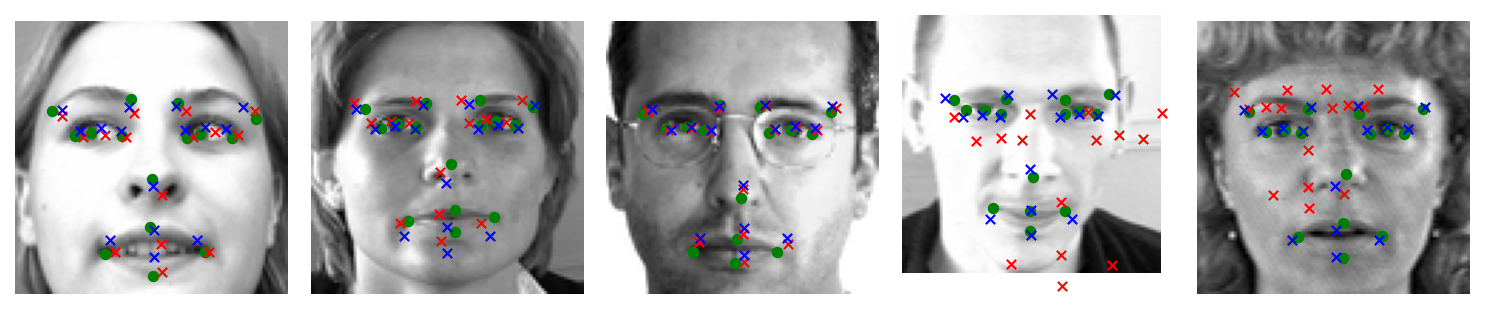

In [44]:
# Choose a few samples from validation to visualize
num_samples_to_show = 5
indices = np.random.choice(len(X_val), size=num_samples_to_show, replace=False)

fig, axes = plt.subplots(1, num_samples_to_show, figsize=(10, 6))
for i, idx in enumerate(indices):
    img = X_val_fcn[idx].reshape(96, 96)
    true_kp = y_val_fcn[idx]
    cnn_pred_kp = val_preds[idx]
    fcn_pred_kp = fcn_model(torch.tensor(X_val_fcn[idx].reshape(1, 96*96)).to(device)).cpu().detach().numpy()[0]

    axes[i].imshow(img, cmap='gray')
    # Plot true keypoints in green
    axes[i].scatter(true_kp[0::2], true_kp[1::2], c='green', s=20, label='True')
    # Plot predicted keypoints in red
    axes[i].scatter(fcn_pred_kp[0::2], fcn_pred_kp[1::2], c='red', s=20, marker='x', label='Pred')
    # Plot predicted keypoints in red
    axes[i].scatter(cnn_pred_kp[0::2], cnn_pred_kp[1::2], c='blue', s=20, marker='x', label='Pred')
    axes[i].axis('off')

plt.tight_layout()
plt.show()